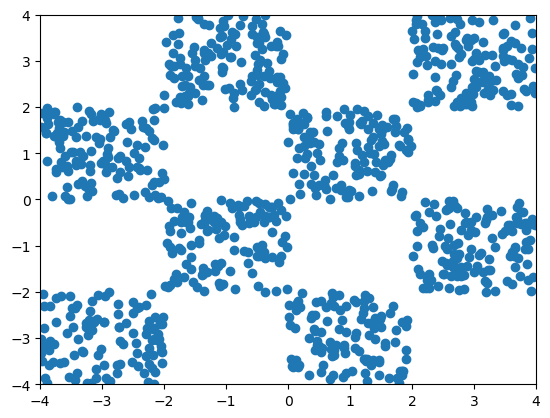

In [1]:
import numpy as np
import matplotlib.pyplot as plt


window_size = (8, 8)
NUM_POINTS = 1000
SIGMA = 1

# Creating the samples from the target distribution (a checkerboard pattern from window_size)
def sample_checkerboard(num_samples):
    # Generate more points than needed to ensure enough after filtering
    oversample = num_samples * 4
    points = np.random.uniform(
        low=[-window_size[0]/2, -window_size[1]/2],
        high=[window_size[0]/2, window_size[1]/2],
        size=(oversample, 2)
    )
    
    # Create checkerboard mask
    checker_size = 2.0  # Size of each checker square
    mask = ((points[:,0] // checker_size + points[:,1] // checker_size) % 2 == 0)
    
    # Keep only points that satisfy the mask
    valid_points = points[mask]
    
    # If we don't have enough points, generate more
    while len(valid_points) < num_samples:
        extra_points = np.random.uniform(
            low=[-window_size[0]/2, -window_size[1]/2],
            high=[window_size[0]/2, window_size[1]/2],
            size=(oversample, 2)
        )
        extra_mask = ((extra_points[:,0] // checker_size + extra_points[:,1] // checker_size) % 2 == 0)
        valid_points = np.vstack([valid_points, extra_points[extra_mask]])
    
    # Randomly select exactly num_samples points
    indices = np.random.choice(len(valid_points), num_samples, replace=False)
    return valid_points[indices]


target_data = sample_checkerboard(NUM_POINTS)

plt.xlim(-window_size[0]/2, window_size[0]/2)
plt.ylim(-window_size[1]/2, window_size[1]/2)
plt.scatter(target_data[:, 0], target_data[:, 1], alpha=1)
plt.show()


# Training code

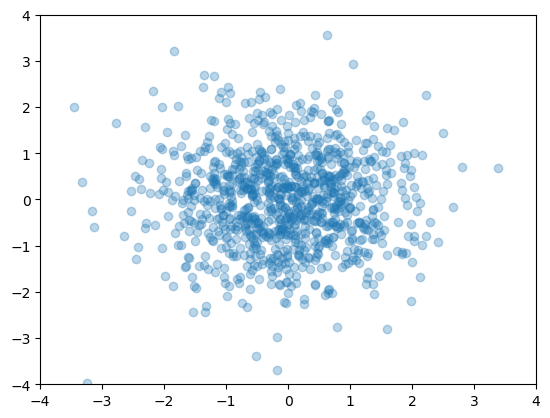

In [2]:



sample = np.random.randn(NUM_POINTS, 2) * SIGMA

np.random.seed(0)

# set radius of scatter plot point to 0.1

plt.xlim(-window_size[0]/2, window_size[0]/2)
plt.ylim(-window_size[1]/2, window_size[1]/2)
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.3)
plt.show()

In [3]:
def noise_schedule(source, target, t):
    return target * t +  source * (1 - t)

100%|██████████| 20000/20000 [00:48<00:00, 409.34it/s]


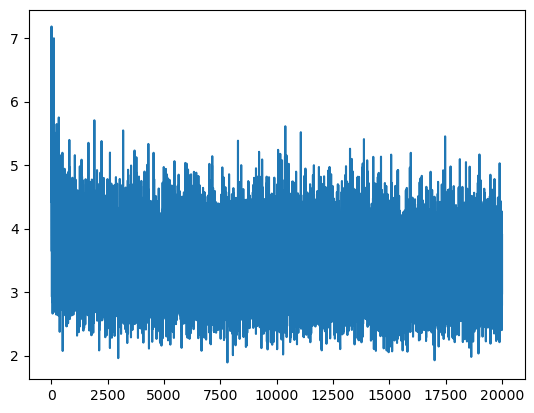

torch.Size([1000, 2])


In [4]:
import torch
from models import FlowMatchingModel
from tqdm import tqdm
NUM_ITERATIONS = 20_000

TimeSteps = 100
batch_size = 64
model = FlowMatchingModel(2, 512, 5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

losses = []

target_data = torch.from_numpy(target_data).float()



for i in tqdm(range(NUM_ITERATIONS)):
    
    # sample from the distributions
    source_data = torch.randn(batch_size, 2)
    target = target_data[torch.randint(target_data.size(0), (batch_size,))]
    
    
    optimal_transport_line = target - source_data
    
    # sample random timestep t  
    t = torch.rand(batch_size)
    
    input_data = noise_schedule(source_data, target, t.unsqueeze(1))
    
    
    # train the flow matching model
    predictions = model.forward(input_data, t)
    
    loss = torch.nn.functional.mse_loss(predictions, optimal_transport_line)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    

plt.plot(losses)
plt.show()
print(target_data.shape)
    

In [5]:
# save model
torch.save(model.state_dict(), 'model.pt')

# Inference

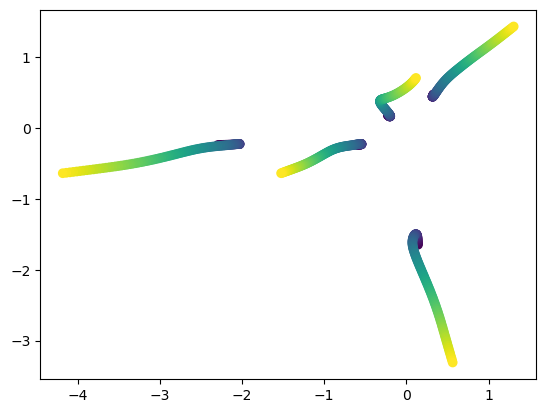

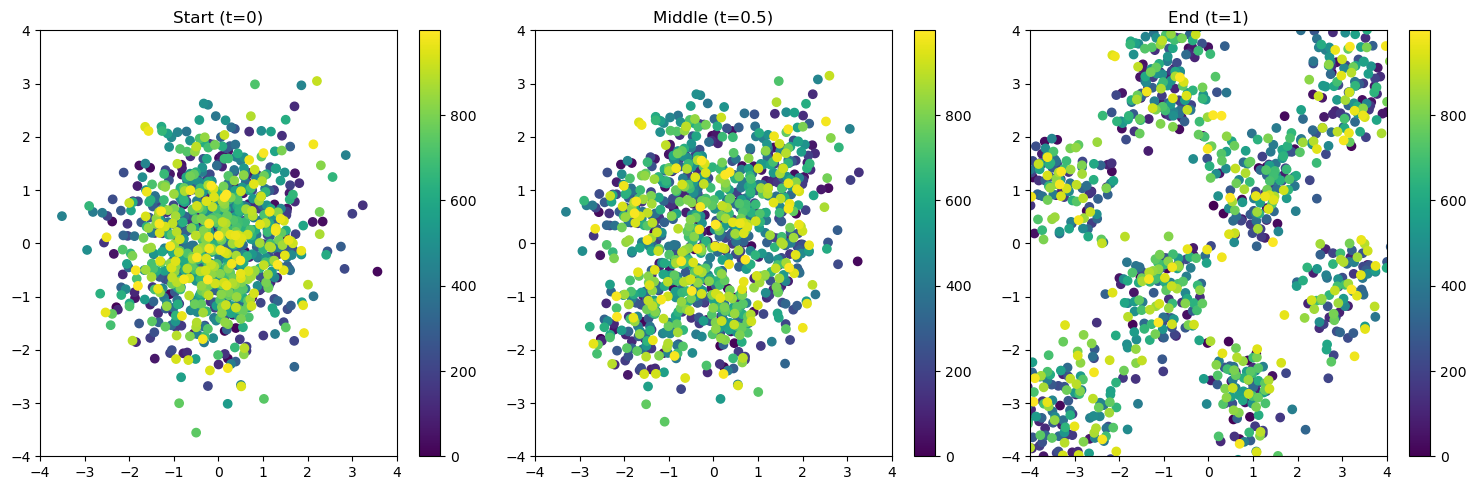

In [6]:
model.eval()

NUM_SAMPLE_POINTS = 1_000

source_data = torch.randn(NUM_SAMPLE_POINTS, 2) * SIGMA

coordinates = torch.zeros((TimeSteps + 1, NUM_SAMPLE_POINTS, 2))

coordinates[0, :, :] = source_data
with torch.no_grad():   
    for i in range(TimeSteps):
        # Current time t
        current_t = i / TimeSteps
        # Next time t + dt
        next_t = (i + 1) / TimeSteps
        # Time step size dt
        dt = 1 / TimeSteps
        
        # Get current point positions
        current_points = coordinates[i, :, :]
        
        # Get vector field at current positions and time
        vector_field = model.forward(current_points, torch.ones(NUM_SAMPLE_POINTS) * next_t)
        
        # Euler step integration: x_{t+dt} = x_t + v_t * dt
        next_points = current_points + vector_field * dt
        
        # Store the new positions
        coordinates[i + 1, :, :] = next_points

plt.scatter(coordinates[:,0,0], coordinates[:,0,1], c=range(TimeSteps+1),cmap='viridis', alpha=1)
plt.scatter(coordinates[:,1,0], coordinates[:,1,1], c=range(TimeSteps+1),cmap='viridis', alpha=1)
plt.scatter(coordinates[:,2,0], coordinates[:,3,1], c=range(TimeSteps+1),cmap='viridis', alpha=1)
plt.scatter(coordinates[:,3,0], coordinates[:,3,1], c=range(TimeSteps+1),cmap='viridis', alpha=1)
plt.scatter(coordinates[:,4,0], coordinates[:,4,1], c=range(TimeSteps+1),cmap='viridis', alpha=1)

plt.show()


# Plot points at start, middle and end
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.scatter(coordinates[0,:,0], coordinates[0,:,1], c=range(NUM_SAMPLE_POINTS), cmap='viridis')
plt.title('Start (t=0)')
plt.xlim(-window_size[0]/2, window_size[0]/2)
plt.ylim(-window_size[1]/2, window_size[1]/2)
plt.colorbar()

plt.subplot(132)
plt.scatter(coordinates[TimeSteps//2,:,0], coordinates[TimeSteps//2,:,1], c=range(NUM_SAMPLE_POINTS), cmap='viridis')
plt.title('Middle (t=0.5)')
plt.xlim(-window_size[0]/2, window_size[0]/2)
plt.ylim(-window_size[1]/2, window_size[1]/2)
plt.colorbar()

plt.subplot(133)
plt.scatter(coordinates[-1,:,0], coordinates[-1,:,1], c=range(NUM_SAMPLE_POINTS), cmap='viridis')
plt.title('End (t=1)')
plt.xlim(-window_size[0]/2, window_size[0]/2)
plt.ylim(-window_size[1]/2, window_size[1]/2)
plt.colorbar()

plt.tight_layout()
plt.savefig('flow_matching.png')
plt.show()



# plot and save the movement of the points as a gif
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
scatter = ax.scatter([], [], c=[], cmap='viridis')
ax.set_xlim(-window_size[0]/2, window_size[0]/2)
ax.set_ylim(-window_size[1]/2, window_size[1]/2)

def animate(frame):
    scatter.set_offsets(coordinates[frame])
    # scatter.set_array(range(NUM_SAMPLE_POINTS) / float(NUM_SAMPLE_POINTS))
    scatter.set_array(np.linspace(0, 1, NUM_SAMPLE_POINTS))
    return scatter,

anim = FuncAnimation(fig, animate, frames=TimeSteps+1, interval=50, blit=True)
anim.save('flow_matching.gif', writer='pillow')
plt.close()


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import os

def create_vector_field_animation(model, save_path='flow_matching_vector_field.gif', 
                                 window_size=window_size, resolution=20, time_steps=TimeSteps, 
                                 sample_points=1000, fps=10, dpi=100):
    """
    Creates and saves a GIF animation of the vector field over time from a flow matching model.
    
    Args:
        model: The trained flow matching model
        save_path: Path to save the GIF animation
        window_size: Tuple of (width, height) for plot window
        resolution: Number of grid points in each dimension for vector field visualization
        time_steps: Number of time steps to visualize
        sample_points: Number of sample points to track through time
        fps: Frames per second for the animation
        dpi: Resolution of the output GIF
    """
    model.eval()
    device = next(model.parameters()).device

    # Create a grid of points for vector field visualization
    x = np.linspace(-window_size[0]/2, window_size[0]/2, resolution)
    y = np.linspace(-window_size[1]/2, window_size[1]/2, resolution)
    X, Y = np.meshgrid(x, y)
    
    # Sample initial points to track through time (Gaussian distribution)
    initial_points = torch.randn(sample_points, 2) * SIGMA
    
    # Store trajectory of points over time
    trajectories = torch.zeros((time_steps + 1, sample_points, 2))
    trajectories[0, :, :] = initial_points
    
    # Function to compute vector field at a specific time
    def compute_vector_field(t_value):
        """Computes vector field at grid points for time t_value"""
        grid_points = torch.from_numpy(np.column_stack((X.flatten(), Y.flatten()))).float().to(device)
        time_tensor = torch.ones(grid_points.shape[0], device=device) * t_value
        
        with torch.no_grad():
            vectors = model(grid_points, time_tensor).cpu().numpy()
        
        # Reshape back to grid
        U = vectors[:, 0].reshape(resolution, resolution)
        V = vectors[:, 1].reshape(resolution, resolution)
        
        # Calculate vector magnitudes for coloring
        magnitudes = np.sqrt(U**2 + V**2)
        
        return U, V, magnitudes
    
    # Compute trajectories
    with torch.no_grad():
        for i in range(time_steps):
            current_t = i / time_steps
            dt = 1 / time_steps
            
            # Current points
            current_points = trajectories[i, :, :].to(device)
            time_tensor = torch.ones(sample_points, device=device) * current_t
            
            # Compute vector field at current points
            vector_field = model(current_points, time_tensor)
            
            # Euler integration
            next_points = current_points + vector_field * dt
            
            # Store
            trajectories[i + 1, :, :] = next_points.cpu()
    
    # Create the animation with vector field
    fig, ax = plt.subplots(figsize=(10, 10), dpi=dpi)
    
    # Function for initialization
    def init():
        ax.clear()
        ax.set_xlim(-window_size[0]/2, window_size[0]/2)
        ax.set_ylim(-window_size[1]/2, window_size[1]/2)
        return []
    
    # Animation function
    def animate(i):
        t_value = i / time_steps
        ax.clear()
        ax.set_xlim(-window_size[0]/2, window_size[0]/2)
        ax.set_ylim(-window_size[1]/2, window_size[1]/2)
        ax.set_title(f'Vector Field at t = {t_value:.2f}')
        
        # Compute vector field
        U, V, magnitudes = compute_vector_field(t_value)
        
        # Create a normalized colormap based on vector magnitudes
        norm = Normalize(vmin=0, vmax=np.max(magnitudes)*1.2)
        
        # Plot vector field with quiver
        quiver = ax.quiver(X, Y, U, V, magnitudes, cmap='plasma', 
                          norm=norm, scale=20, width=0.003)
        
        # Plot trajectory points up to current time
        if i > 0:
            points = trajectories[i, :, :].numpy()
            # Color by vector magnitude
            point_vectors = model(
                torch.tensor(points, device=device),
                torch.ones(points.shape[0], device=device) * t_value
            ).detach().cpu().numpy()
            point_magnitudes = np.sqrt(point_vectors[:, 0]**2 + point_vectors[:, 1]**2)
            scatter = ax.scatter(points[:, 0], points[:, 1], 
                               c=point_magnitudes, cmap='viridis', 
                               norm=norm, s=10, alpha=0.7)
        
        # Add colorbar
        if i == 0:
            cbar = plt.colorbar(quiver, ax=ax)
            cbar.set_label('Vector Magnitude')
        
        return [quiver]
    
    # Create animation
    anim = FuncAnimation(
        fig, animate, init_func=init,
        frames=time_steps+1, interval=1000/fps, blit=False)
    
    # Save animation
    print(f"Saving animation to {save_path}...")
    anim.save(save_path, writer='pillow', fps=fps)
    plt.close(fig)
    print(f"Animation saved successfully!")
    
    # Create and save an animation with only the dots (no vector field)
    dots_save_path = os.path.splitext(save_path)[0] + '_dots_only.gif'
    fig_dots, ax_dots = plt.subplots(figsize=(10, 10), dpi=dpi)
    
    def init_dots():
        ax_dots.clear()
        ax_dots.set_xlim(-window_size[0]/2, window_size[0]/2)
        ax_dots.set_ylim(-window_size[1]/2, window_size[1]/2)
        return []
    
    def animate_dots(i):
        t_value = i / time_steps
        ax_dots.clear()
        ax_dots.set_xlim(-window_size[0]/2, window_size[0]/2)
        ax_dots.set_ylim(-window_size[1]/2, window_size[1]/2)
        ax_dots.set_title(f'Particles Flow at t = {t_value:.2f}')
        
        # Plot only the trajectory points at current time
        if i > 0:
            points = trajectories[i, :, :].numpy()
            # Color by vector magnitude
            point_vectors = model(
                torch.tensor(points, device=device),
                torch.ones(points.shape[0], device=device) * t_value
            ).detach().cpu().numpy()
            point_magnitudes = np.sqrt(point_vectors[:, 0]**2 + point_vectors[:, 1]**2)
            
            # Use a larger dot size for better visibility
            scatter = ax_dots.scatter(points[:, 0], points[:, 1], 
                                    c=point_magnitudes, cmap='viridis', 
                                    s=30, alpha=0.8)
            
            # Add colorbar
            if i == 1:  # Add colorbar on first frame with dots
                cbar = plt.colorbar(scatter, ax=ax_dots)
                cbar.set_label('Vector Magnitude')
                
        return []
    
    # Create dots-only animation
    anim_dots = FuncAnimation(
        fig_dots, animate_dots, init_func=init_dots,
        frames=time_steps+1, interval=1000/fps, blit=False)
    
    # Save dots-only animation
    print(f"Saving dots-only animation to {dots_save_path}...")
    anim_dots.save(dots_save_path, writer='pillow', fps=fps)
    plt.close(fig_dots)
    print(f"Dots-only animation saved successfully!")
    
    # Create an additional plot showing the full trajectories
    plt.figure(figsize=(10, 10), dpi=dpi, frameon=False)
    plt.title("Full Trajectories")
    plt.axis('off')
    
    
    # Plot full trajectories with gradual color change
    for i in range(sample_points):
        points = trajectories[:, i, :].numpy()
        # Color gradient from blue to red
        colors = plt.cm.viridis(np.linspace(0, 1, time_steps+1))
        for j in range(time_steps):
            plt.plot(points[j:j+2, 0], points[j:j+2, 1], color=colors[j], alpha=0.5)
    
    # Plot start and end points
    plt.scatter(trajectories[0, :, 0], trajectories[0, :, 1], 
               color='blue', s=30, label='Start (t=0)')
    plt.scatter(trajectories[-1, :, 0], trajectories[-1, :, 1], 
               color='red', s=30, label='End (t=1)')
    
    plt.legend()
    plt.xlim(-window_size[0]/2, window_size[0]/2)
    plt.ylim(-window_size[1]/2, window_size[1]/2)
    plt.savefig(os.path.splitext(save_path)[0] + '_trajectories.png')
    plt.close()
    
    return trajectories

# Example usage
def visualize_flow_model(model, window_size=window_size):
    """
    Wrapper function to visualize a flow matching model.
    
    Args:
        model: The trained flow matching model
        sigma: Standard deviation for initial distribution
        window_size: Size of the visualization window
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Create directory for output if it doesn't exist
    os.makedirs('flow_visualizations', exist_ok=True)
    
    # Generate and save vector field animation
    trajectories = create_vector_field_animation(
        model=model,
        save_path='flow_visualizations/vector_field_animation.gif',
        window_size=window_size,
        resolution=20,  # Grid resolution for vector field
        time_steps=40,  # Number of time steps to visualize
        sample_points=200,  # Number of sample points to track
        fps=10,
        dpi=100
    )
    
    # Generate additional visualization showing evolution of density
    time_snapshots = [0.0, 0.25, 0.5, 0.75, 1.0]
    fig, axes = plt.subplots(1, len(time_snapshots), figsize=(15, 4), dpi=100)
    
    for i, t in enumerate(time_snapshots):
        t_idx = int(t * 40)  # Assuming 40 time steps as above
        if t_idx >= len(trajectories):
            t_idx = len(trajectories) - 1
            
        points = trajectories[t_idx].numpy()
        axes[i].scatter(points[:, 0], points[:, 1], s=5, alpha=0.5, c='blue')
        axes[i].set_title(f't = {t:.2f}')
        axes[i].set_xlim(-window_size[0]/2, window_size[0]/2)
        axes[i].set_ylim(-window_size[1]/2, window_size[1]/2)
        axes[i].set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('flow_visualizations/density_evolution.png')
    plt.close()
    
    print("All visualizations completed successfully!")
    
    return trajectories

visualize_flow_model(model)

Saving animation to flow_visualizations/vector_field_animation.gif...
Animation saved successfully!
Saving dots-only animation to flow_visualizations/vector_field_animation_dots_only.gif...
Dots-only animation saved successfully!
All visualizations completed successfully!


tensor([[[-1.7159, -0.2193],
         [-0.5733, -0.8492],
         [-0.3783,  0.4742],
         ...,
         [-0.6599, -0.8836],
         [ 1.3453, -0.5076],
         [-0.1634,  1.7514]],

        [[-1.6727, -0.2234],
         [-0.5538, -0.8322],
         [-0.3652,  0.4603],
         ...,
         [-0.6383, -0.8668],
         [ 1.3116, -0.4932],
         [-0.1516,  1.7160]],

        [[-1.6343, -0.2266],
         [-0.5374, -0.8170],
         [-0.3543,  0.4488],
         ...,
         [-0.6198, -0.8517],
         [ 1.2815, -0.4799],
         [-0.1410,  1.6850]],

        ...,

        [[-3.3198,  0.1091],
         [-2.0830, -2.3524],
         [-0.9448,  2.0660],
         ...,
         [-2.2750, -2.5016],
         [ 2.9677, -0.9326],
         [-0.6300,  3.5126]],

        [[-3.4044,  0.1177],
         [-2.1477, -2.4243],
         [-0.9668,  2.1311],
         ...,
         [-2.3448, -2.5760],
         [ 3.0440, -0.9540],
         [-0.6474,  3.6091]],

        [[-3.4900,  0.1254],
       

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import os
from scipy.stats import gaussian_kde

def create_density_field_animation(model, save_path='flow_matching_density_field.gif', 
                                  window_size=window_size, resolution=100, time_steps=TimeSteps, 
                                  sample_points=2000, fps=10, dpi=100, kde_bandwidth=0.1):
    """
    Creates and saves a GIF animation of the density field over time from a flow matching model.
    
    Args:
        model: The trained flow matching model
        save_path: Path to save the GIF animation
        window_size: Tuple of (width, height) for plot window
        resolution: Number of grid points in each dimension for density field
        time_steps: Number of time steps to visualize
        sample_points: Number of sample points to track through time
        fps: Frames per second for the animation
        dpi: Resolution of the output GIF
        kde_bandwidth: Bandwidth parameter for kernel density estimation
    """
    model.eval()
    device = next(model.parameters()).device

    # Create a grid of points for density estimation
    x = np.linspace(-window_size[0]/2, window_size[0]/2, resolution)
    y = np.linspace(-window_size[1]/2, window_size[1]/2, resolution)
    X, Y = np.meshgrid(x, y)
    grid_coordinates = np.vstack([X.ravel(), Y.ravel()]).T
    
    # Sample initial points to track through time (Gaussian distribution)
    initial_points = torch.randn(sample_points, 2) * SIGMA
    
    # Store trajectory of points over time
    trajectories = torch.zeros((time_steps + 1, sample_points, 2))
    trajectories[0, :, :] = initial_points
    
    # Compute trajectories
    print("Computing particle trajectories...")
    with torch.no_grad():
        for i in range(time_steps):
            current_t = i / time_steps
            dt = 1 / time_steps
            
            # Current points
            current_points = trajectories[i, :, :].to(device)
            time_tensor = torch.ones(sample_points, device=device) * current_t
            
            # Compute vector field at current points
            vector_field = model(current_points, time_tensor)
            
            # Euler integration
            next_points = current_points + vector_field * dt
            
            # Store
            trajectories[i + 1, :, :] = next_points.cpu()
    
    # Pre-compute density estimates for each time step
    print("Pre-computing density estimations for each frame...")
    density_grids = []
    
    for i in range(time_steps + 1):
        points = trajectories[i, :, :].numpy()
        
        # Compute KDE
        kde = gaussian_kde(points.T, bw_method=kde_bandwidth)
        density = kde(np.vstack([X.ravel(), Y.ravel()]))
        density = density.reshape(X.shape)
        
        density_grids.append(density)
    
    # Find global max density for consistent colormap scaling
    max_density = max(np.max(grid) for grid in density_grids)
    
    # Create the animation
    print("Creating density field animation...")
    fig, ax = plt.subplots(figsize=(10, 10), dpi=dpi, frameon=False)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # Function for initialization
    def init():
        ax.clear()
        ax.set_xlim(-window_size[0]/2, window_size[0]/2)
        ax.set_ylim(-window_size[1]/2, window_size[1]/2)
        ax.set_axis_off()
        return []
    
    # Animation function for density field
    def animate(i):
        t_value = i / time_steps
        ax.clear()
        ax.set_xlim(-window_size[0]/2, window_size[0]/2)
        ax.set_ylim(-window_size[1]/2, window_size[1]/2)
        ax.set_title(f'Density Field at t = {t_value:.2f}')
        
        # Get pre-computed density for this time step
        density = density_grids[i]
        
        # Plot density field using contourf
        contour = ax.contourf(X, Y, density, 
                             levels=50, 
                             cmap='viridis', 
                             vmin=0, 
                             vmax=max_density,)
                            #  alpha=0.85)
        return [contour]
    
    # Create animation
    anim = FuncAnimation(
        fig, animate, init_func=init,
        frames=time_steps+1, interval=1000/fps, blit=False)
    
    # Save animation
    print(f"Saving density field animation to {save_path}...")
    anim.save(save_path, writer='pillow', fps=fps)
    plt.close(fig)
    print(f"Density field animation saved successfully!")
    
    # Create an optional combined visualization with both density and vector field
    combined_save_path = os.path.splitext(save_path)[0] + '_with_vectors.gif'
    fig_combined, ax_combined = plt.subplots(figsize=(10, 10), dpi=dpi, frameon=False)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # Create a grid of points for vector field visualization (sparser than density)
    vector_resolution = 15  # Fewer points for cleaner visualization
    x_vec = np.linspace(-window_size[0]/2, window_size[0]/2, vector_resolution)
    y_vec = np.linspace(-window_size[1]/2, window_size[1]/2, vector_resolution)
    X_vec, Y_vec = np.meshgrid(x_vec, y_vec)
    
    # Function to compute vector field at a specific time
    def compute_vector_field(t_value):
        """Computes vector field at grid points for time t_value"""
        grid_points = torch.from_numpy(np.column_stack((X_vec.flatten(), Y_vec.flatten()))).float().to(device)
        time_tensor = torch.ones(grid_points.shape[0], device=device) * t_value
        
        with torch.no_grad():
            vectors = model(grid_points, time_tensor).cpu().numpy()
        
        # Reshape back to grid
        U = vectors[:, 0].reshape(vector_resolution, vector_resolution)
        V = vectors[:, 1].reshape(vector_resolution, vector_resolution)
        
        # Calculate vector magnitudes for scaling
        magnitudes = np.sqrt(U**2 + V**2)
        
        return U, V, magnitudes
    
    def init_combined():
        ax_combined.clear()
        ax_combined.set_xlim(-window_size[0]/2, window_size[0]/2)
        ax_combined.set_ylim(-window_size[1]/2, window_size[1]/2)
        ax_combined.set_axis_off()
        return []
    
    def animate_combined(i):
        t_value = i / time_steps
        ax_combined.clear()
        ax_combined.set_xlim(-window_size[0]/2, window_size[0]/2)
        ax_combined.set_ylim(-window_size[1]/2, window_size[1]/2)
        
        # Get pre-computed density for this time step
        density = density_grids[i]
        
        # Plot density field using contourf
        contour = ax_combined.contourf(X, Y, density, 
                                      levels=50, 
                                      cmap='plasma', 
                                      vmin=0, 
                                      vmax=max_density,)
                                    #   alpha=0.7)
        
        # Compute and plot vector field
        U, V, magnitudes = compute_vector_field(t_value)
        
        # Plot vector field with quiver
        quiver = ax_combined.quiver(X_vec, Y_vec, U, V, 
                                   color='white', 
                                   scale=50, 
                                   width=0.003)
                                #    alpha=0.7)
        
        return [contour, quiver]
    
    # Create combined animation
    print("Creating combined density and vector field animation...")
    anim_combined = FuncAnimation(
        fig_combined, animate_combined, init_func=init_combined,
        frames=time_steps+1, interval=1000/fps, blit=False)
    
    # Save combined animation
    print(f"Saving combined animation to {combined_save_path}...")
    anim_combined.save(combined_save_path, writer='pillow', fps=fps)
    plt.close(fig_combined)
    print(f"Combined animation saved successfully!")
    
    return trajectories, density_grids

def visualize_flow_model(model, window_size=window_size):
    """
    Wrapper function to visualize a flow matching model.
    
    Args:
        model: The trained flow matching model
        window_size: Size of the visualization window
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Create directory for output if it doesn't exist
    os.makedirs('flow_visualizations', exist_ok=True)
    
    # Generate and save density field animation
    trajectories, density_grids = create_density_field_animation(
        model=model,
        save_path='flow_visualizations/density_field_animation.gif',
        window_size=window_size,
        resolution=100,  # Higher resolution for smoother density
        time_steps=40,   # Number of time steps to visualize
        sample_points=10_000,  # More sample points for better density estimation
        fps=10,
        dpi=100,
        kde_bandwidth=0.1  # Adjust this parameter to control smoothness
    )
    
    # Generate snapshots showing evolution of density at specific time points
    time_snapshots = [0.0, 0.25, 0.5, 0.75, 1.0]
    fig, axes = plt.subplots(1, len(time_snapshots), figsize=(15, 4), dpi=150)
    
    max_density = max(np.max(grid) for grid in density_grids)
    
    # Create a grid for evaluation
    x = np.linspace(-window_size[0]/2, window_size[0]/2, 100)
    y = np.linspace(-window_size[1]/2, window_size[1]/2, 100)
    X, Y = np.meshgrid(x, y)
    
    for i, t in enumerate(time_snapshots):
        t_idx = int(t * 40)  # Assuming 40 time steps as above
        if t_idx >= len(density_grids):
            t_idx = len(density_grids) - 1
            
        # Get pre-computed density
        density = density_grids[t_idx]
        
        # Plot density field
        contour = axes[i].contourf(X, Y, density, levels=50, cmap='viridis', vmin=0, vmax=max_density)
        axes[i].set_title(f't = {t:.2f}')
        axes[i].set_xlim(-window_size[0]/2, window_size[0]/2)
        axes[i].set_ylim(-window_size[1]/2, window_size[1]/2)
        
    plt.tight_layout()
    cbar = plt.colorbar(contour, ax=axes)
    cbar.set_label('Density')
    plt.savefig('flow_visualizations/density_snapshots.png')
    plt.close()
    
    print("All visualizations completed successfully!")
    
    return trajectories, density_grids

# Example usage
visualize_flow_model(model)

Computing particle trajectories...
Pre-computing density estimations for each frame...
Creating density field animation...
Saving density field animation to flow_visualizations/density_field_animation.gif...
Density field animation saved successfully!
Creating combined density and vector field animation...
Saving combined animation to flow_visualizations/density_field_animation_with_vectors.gif...
Combined animation saved successfully!
All visualizations completed successfully!


(tensor([[[-1.0129, -0.2820],
          [ 0.2946, -0.6688],
          [ 0.2327,  1.1720],
          ...,
          [ 0.8415, -0.4186],
          [-1.3703,  0.6746],
          [-0.2094,  0.4415]],
 
         [[-0.9844, -0.2812],
          [ 0.2845, -0.6513],
          [ 0.2327,  1.1449],
          ...,
          [ 0.8186, -0.4071],
          [-1.3403,  0.6550],
          [-0.2003,  0.4287]],
 
         [[-0.9600, -0.2799],
          [ 0.2756, -0.6363],
          [ 0.2329,  1.1218],
          ...,
          [ 0.7984, -0.3967],
          [-1.3144,  0.6378],
          [-0.1925,  0.4181]],
 
         ...,
 
         [[-2.1708, -0.4092],
          [ 0.3234, -1.6755],
          [ 0.3318,  2.6509],
          ...,
          [ 2.3993, -0.8197],
          [-3.1468,  1.3151],
          [-0.2032,  1.8542]],
 
         [[-2.2202, -0.4178],
          [ 0.3310, -1.7221],
          [ 0.3261,  2.7203],
          ...,
          [ 2.4632, -0.8390],
          [-3.2291,  1.3457],
          [-0.2032,  1.9108